In [2]:
import math
import numpy
from scipy import integrate
from matplotlib import pyplot
# embed the figures into the notebook
%matplotlib inline

In [3]:
u_inf = 1.0  

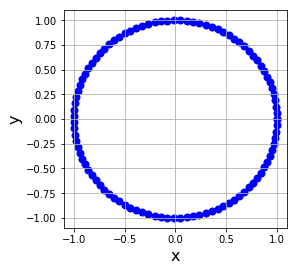

In [4]:
R = 1.0
x_center, y_center = 0.0, 0.0
theta = numpy.linspace(0.0, 2 * math.pi, 100)
x_cylinder, y_cylinder = (x_center + R * numpy.cos(theta),y_center + R * numpy.sin(theta))
size = 4
pyplot.figure(figsize=(size, size))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.scatter(x_cylinder, y_cylinder, color='b', linestyle='-', linewidth=2)
pyplot.xlim(-1.1, 1.1)
pyplot.ylim(-1.1, 1.1);

In [5]:
class Panel:
    def __init__(self,xa,ya,xb,yb):
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2
        self.length = math.sqrt((xb - xa)**2 + (yb - ya)**2)
        
        if xb - xa <= 0.:
            self.beta = math.acos((yb - ya) / self.length)
        elif xb - xa > 0.:
            self.beta = math.pi + math.acos(-(yb - ya) / self.length)
            
        self.sigma = 0.0
        self.vt = vt = 0.0
        self.cp = 0.0
        

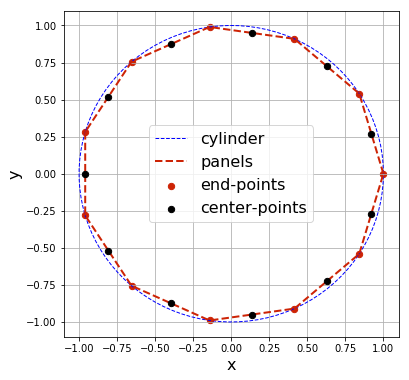

In [25]:
N_panels = 11

x_ends = R * numpy.cos(numpy.linspace(0.0, 2 * math.pi, N_panels + 1))
y_ends = R * numpy.sin(numpy.linspace(0.0, 2 * math.pi, N_panels + 1))

panels = numpy.empty(N_panels, dtype=object)
for i in range(N_panels):
    panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i + 1], y_ends[i + 1])

    
size = 6

pyplot.figure(figsize=(size, size))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_cylinder, y_cylinder,
            label='cylinder',
            color='b', linestyle='--', linewidth=1)
pyplot.plot(x_ends, y_ends,
            label='panels',
            color='#CD2305', linestyle='--', linewidth=2)
pyplot.scatter([p.xa for p in panels], [p.ya for p in panels],
               label='end-points',
               color='#CD2305', s=40)
pyplot.scatter([p.xc for p in panels], [p.yc for p in panels],
               label='center-points',
               color='k', s=40, zorder=3)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-1.1, 1.1)
pyplot.ylim(-1.1, 1.1);

In [ ]:
N = 200                               # Number of points in each direction
x_start, x_end = -4.0, 4.0            # x-direction boundaries
y_start, y_end = -2.0, 2.0            # y-direction boundaries
x = numpy.linspace(x_start, x_end, N)    # 1D-array for x
y = numpy.linspace(y_start, y_end, N)    # 1D-array for y
X, Y = numpy.meshgrid(x, y) 